In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote, urlparse
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# Set visual style for plots
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv('/kaggle/input/lsay-dataset/30263-0001-Data.csv')

In [4]:

# Define variables related to fall and spring semesters
fall_vars = [
    'GAMTH1C', 'GAMTH1D', 'GAMTH1E', 'GAMTH1H', 'GAMTH2C',
    'GASCI1D', 'GASCI1E', 'GASCI1H', 'GASCI2C', 'GASCI2D',
    'GAENG1C', 'GAENG1D', 'GAENG1E', 'GAENG2C', 'GAENG2D',
    'GASSTC', 'GASSTD', 'GACOMC', 'GACOMD', 'GAFORC',
    'GAARTC', 'GAMUSC', 'GAVOCC', 'GA32A', 'GA32D',
    'GA33A', 'GA33D'
]

spring_vars = [
    'HAMTH1C', 'HAMTH1D', 'HAMTH2C', 'HASCI1C', 'HASCI2C',
    'HAENG1C', 'HAENG2C', 'HASSTC', 'HACOMC',
    'HAFORC', 'HAARTC', 'HAMUSC', 'HAVOCC'
]

In [5]:
# Filter data for fall and spring semesters
fall_data = df[fall_vars].copy()
spring_data = df[spring_vars].copy()

In [7]:
# Encode target variable (college major)
label_encoder = LabelEncoder()
df['LAMAJOR8I_encoded'] = label_encoder.fit_transform(df['LAMAJOR8I'])

In [9]:
# Correct SettingWithCopyWarning for fall and spring data
fall_data['LAMAJOR8I'] = df['LAMAJOR8I']
spring_data['LAMAJOR8I'] = df['LAMAJOR8I']

In [11]:
# Split data into training and test sets for both semesters
X_fall = fall_data.drop('LAMAJOR8I', axis=1)
y_fall = fall_data['LAMAJOR8I']
X_spring = spring_data.drop('LAMAJOR8I', axis=1)
y_spring = spring_data['LAMAJOR8I']

X_fall_train, X_fall_test, y_fall_train, y_fall_test = train_test_split(X_fall, y_fall, test_size=0.2, random_state=42)
X_spring_train, X_spring_test, y_spring_train, y_spring_test = train_test_split(X_spring, y_spring, test_size=0.2, random_state=42)

In [13]:
# Handling class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_fall_train_resampled, y_fall_train_resampled = sm.fit_resample(X_fall_train, y_fall_train)
X_spring_train_resampled, y_spring_train_resampled = sm.fit_resample(X_spring_train, y_spring_train)


In [14]:
# Standardize features
scaler = StandardScaler()
X_fall_train_resampled = scaler.fit_transform(X_fall_train_resampled)
X_fall_test = scaler.transform(X_fall_test)
X_spring_train_resampled = scaler.fit_transform(X_spring_train_resampled)
X_spring_test = scaler.transform(X_spring_test)

In [16]:
# Hyperparameter tuning with GridSearchCV for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [17]:
grid_search_fall = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_spring = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit models with the best parameters
grid_search_fall.fit(X_fall_train_resampled, y_fall_train_resampled)
grid_search_spring.fit(X_spring_train_resampled, y_spring_train_resampled)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   8.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   6.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   8.5s

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   9.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   6.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   8.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, m

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   8.6s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, mi

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [20]:
# Best model evaluation
best_fall_model = grid_search_fall.best_estimator_
best_spring_model = grid_search_spring.best_estimator_


In [21]:
# Predictions
y_fall_pred = best_fall_model.predict(X_fall_test)
y_spring_pred = best_spring_model.predict(X_spring_test)

In [22]:
# Evaluate models
print("Best Fall Semester Model Evaluation:")
print(confusion_matrix(y_fall_test, y_fall_pred))
print(classification_report(y_fall_test, y_fall_pred))

print("Best Spring Semester Model Evaluation:")
print(confusion_matrix(y_spring_test, y_spring_pred))
print(classification_report(y_spring_test, y_spring_pred))

Best Fall Semester Model Evaluation:
[[  0   0   0   0   1   0   0   0   0   0   0   0]
 [  0 386  12   1  10   1  18  15  16  56  23  45]
 [  0  11   3   0   0   0  11   1   2   3   2   3]
 [  0   4   0   0   0   0   0   0   0   1   0   0]
 [  0  14   1   4   3   0   6   2   1   2   7   0]
 [  0   2   0   0   0   0   0   0   0   2   1   1]
 [  0  19   4   0   5   0   0   6   3  12   8   1]
 [  1  14   2   0   2   0   3   2   3   8   8   4]
 [  0  29   4   0   1   0   3   4   9  10   7   5]
 [  1  79   2   3   4   1   6   3   4  20  12  10]
 [  0  34   1   0   3   1   4   3   3  15   5   3]
 [  0  68   3   1   4   0   7   4   6  16   7   8]]
              precision    recall  f1-score   support

         -95       0.00      0.00      0.00         1
           0       0.58      0.66      0.62       583
           1       0.09      0.08      0.09        36
           2       0.00      0.00      0.00         5
           3       0.09      0.07      0.08        40
           4       0.00  

In [23]:
# Cross-validation scores
cv_scores_fall = cross_val_score(best_fall_model, X_fall_train_resampled, y_fall_train_resampled, cv=5)
cv_scores_spring = cross_val_score(best_spring_model, X_spring_train_resampled, y_spring_train_resampled, cv=5)

print(f"Cross-validation scores (Fall): {cv_scores_fall}")
print(f"Cross-validation scores (Spring): {cv_scores_spring}")


Cross-validation scores (Fall): [0.85379906 0.90673389 0.91303565 0.91590131 0.91193949]
Cross-validation scores (Spring): [0.72560317 0.77925819 0.7817789  0.79488565 0.79110391]


In [25]:
# Feature importance for both semesters
fall_feature_importance = pd.DataFrame(best_fall_model.feature_importances_, index=X_fall.columns, columns=['Importance']).sort_values('Importance', ascending=False)
spring_feature_importance = pd.DataFrame(best_spring_model.feature_importances_, index=X_spring.columns, columns=['Importance']).sort_values('Importance', ascending=False)

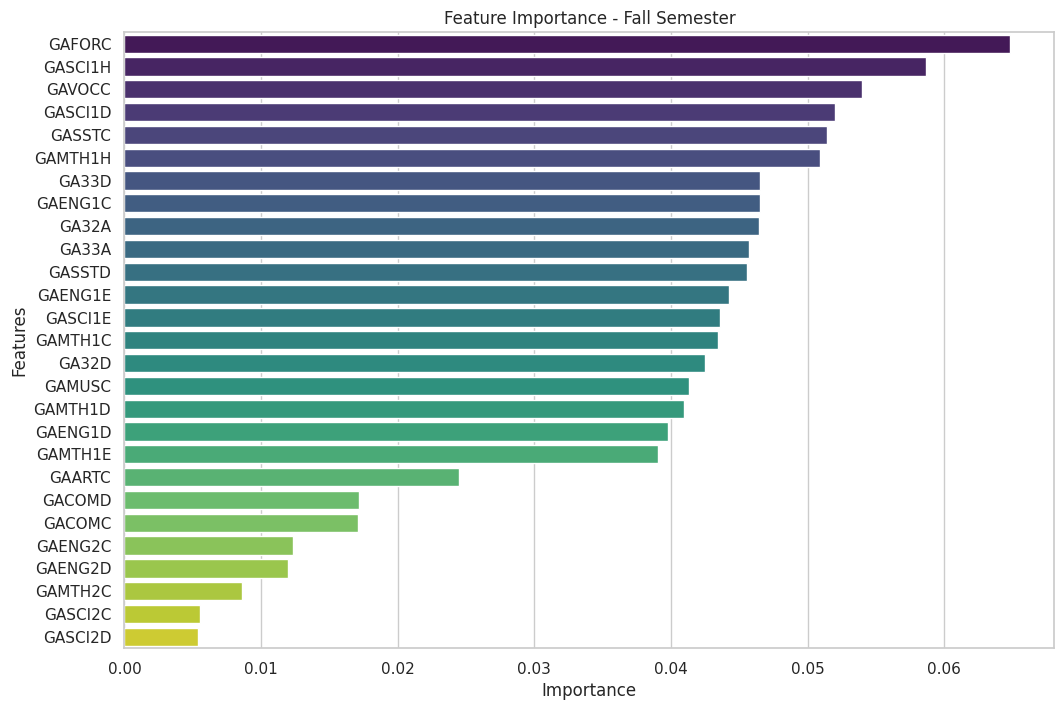

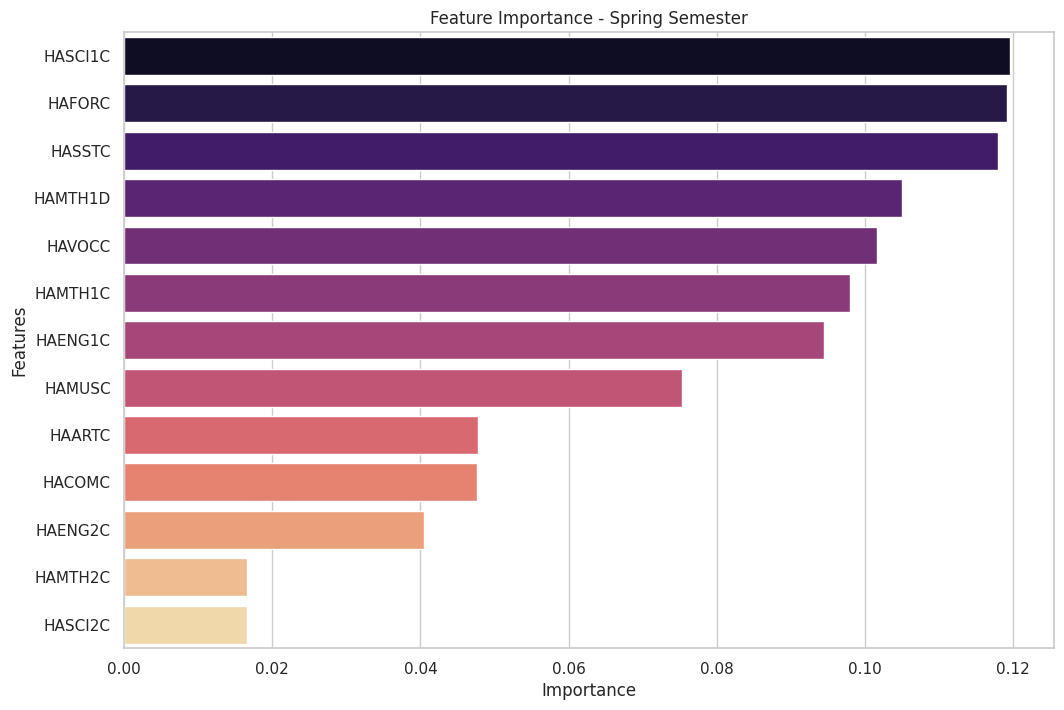

In [26]:
# Plotting feature importance for fall and spring semesters
plt.figure(figsize=(12, 8))
sns.barplot(x=fall_feature_importance.Importance, y=fall_feature_importance.index, palette='viridis')
plt.title('Feature Importance - Fall Semester')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=spring_feature_importance.Importance, y=spring_feature_importance.index, palette='magma')
plt.title('Feature Importance - Spring Semester')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

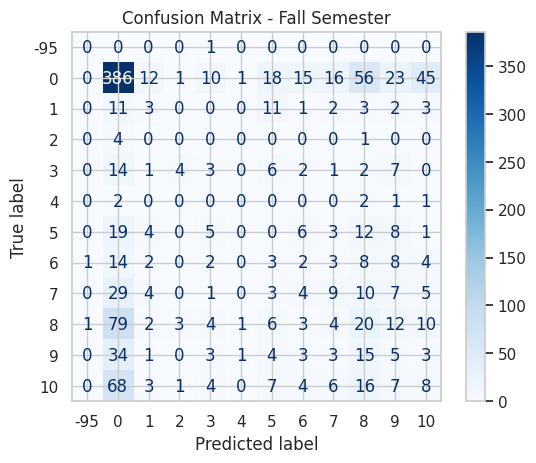

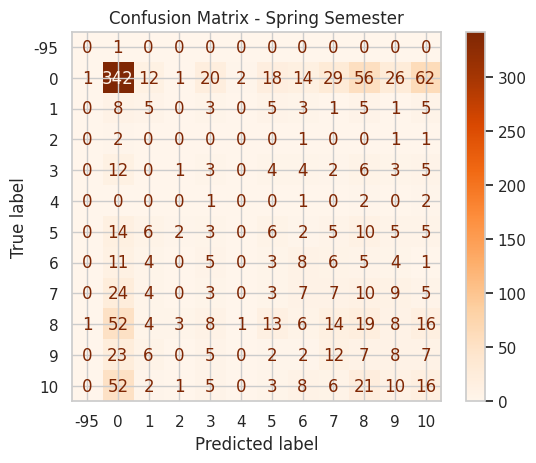

In [27]:
# Plot confusion matrix for fall and spring
cm_fall = confusion_matrix(y_fall_test, y_fall_pred)
ConfusionMatrixDisplay(cm_fall, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix - Fall Semester')
plt.show()

cm_spring = confusion_matrix(y_spring_test, y_spring_pred)
ConfusionMatrixDisplay(cm_spring, display_labels=label_encoder.classes_).plot(cmap='Oranges')
plt.title('Confusion Matrix - Spring Semester')
plt.show()


In [29]:
# ROC curve for fall and spring
y_fall_test_binarized = label_binarize(y_fall_test, classes=np.unique(y_fall_test))
y_spring_test_binarized = label_binarize(y_spring_test, classes=np.unique(y_spring_test))
n_classes = y_fall_test_binarized.shape[1]


In [31]:
# One-vs-Rest (OvR) classification for ROC curve
ovr_fall = OneVsRestClassifier(best_fall_model)
ovr_fall.fit(X_fall_train_resampled, y_fall_train_resampled)

ovr_spring = OneVsRestClassifier(best_spring_model)
ovr_spring.fit(X_spring_train_resampled, y_spring_train_resampled)

fpr_fall, tpr_fall, roc_auc_fall = dict(), dict(), dict()
fpr_spring, tpr_spring, roc_auc_spring = dict(), dict(), dict()

for i in range(n_classes):
    fpr_fall[i], tpr_fall[i], _ = roc_curve(y_fall_test_binarized[:, i], ovr_fall.predict_proba(X_fall_test)[:, i])
    roc_auc_fall[i] = auc(fpr_fall[i], tpr_fall[i])
    
    fpr_spring[i], tpr_spring[i], _ = roc_curve(y_spring_test_binarized[:, i], ovr_spring.predict_proba(X_spring_test)[:, i])
    roc_auc_spring[i] = auc(fpr_spring[i], tpr_spring[i])


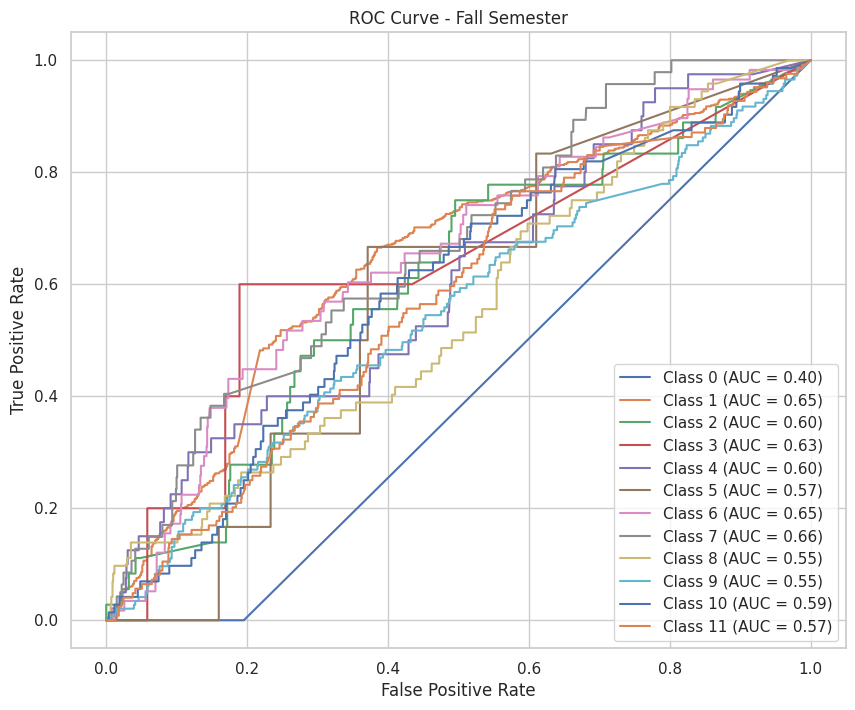

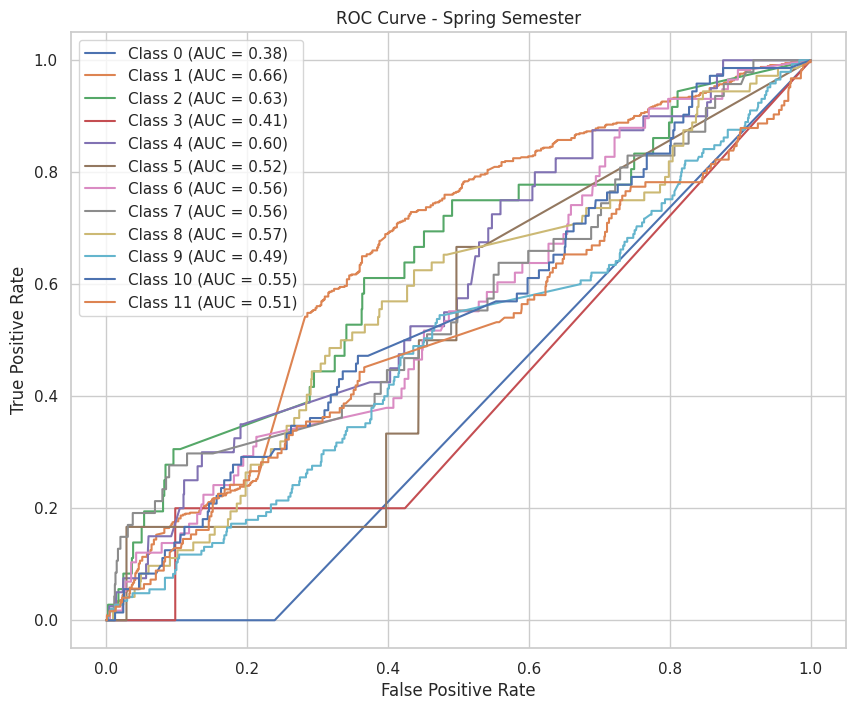

In [32]:
# Plot ROC curves for fall and spring semesters
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_fall[i], tpr_fall[i], label=f'Class {i} (AUC = {roc_auc_fall[i]:.2f})')
plt.title('ROC Curve - Fall Semester')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_spring[i], tpr_spring[i], label=f'Class {i} (AUC = {roc_auc_spring[i]:.2f})')
plt.title('ROC Curve - Spring Semester')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()